In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import multiprocessing as mp
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from operator import xor

In [3]:
from classifier import *
from ntk import *
from Q_minimization import *
from train import *

### Define Dimensions

In [345]:
n = 5
m = 20
d = 3

### Define Dataset

In [346]:
# x = np.array([[1, -0.8, -0.5], [1, -0.4, -0.5], [1, 0.15, 0.3]])
# y = np.array([[1.0, -1.0, 1.0]]).reshape(-1,)
# dataset = '3PTS'

In [381]:
x = array([[ 1.        , -0.77859717,  0.91411701],
       [ 1.        , -0.93180691,  0.78863155],
       [ 1.        ,  0.17577044, -0.91032515],
       [ 1.        ,  0.65264079,  0.85918343],
       [ 1.        ,  0.90145257, -0.833918  ]])
y = array([-1, -1,  1,  1, -1])
dataset = 'COLT_A'

In [382]:
# def create_sample():
#     cluster_centers = [-0.8, 0, 0.8]
#     choice = np.random.choice(cluster_centers, size=2, replace=True)
    
#     y_sample = -1
#     if (choice[0] != -choice[1]) and not (choice[0] == 0.8 and choice[1] == 0):
#         y_sample = 1    
    
#     choice += np.random.normal(loc=0, scale=0.1, size=(2,))
#     x_sample = np.concatenate([np.ones((1, )), choice])

#     return x_sample.reshape(1, -1), y_sample

In [383]:
# samples = [create_sample() for _ in range(n)]
# x = np.concatenate([sample[0] for sample in samples])
# y = np.array([sample[1] for sample in samples]).reshape(-1,)
# dataset = 'COLT'

### Solve L1

In [384]:
w_0 = np.random.normal(loc=0, scale=1, size=(m, d))
a_0 = np.random.normal(loc=0, scale=1, size=(m,))

In [385]:
w_opt_L1, a_opt_L1 = solver(x, y, w_0, a_0, m, d, obj='L1')
w_opt_L1, a_opt_L1

(array([[ 5.45633484e-02, -7.77385070e-01, -7.74911270e-01],
        [-3.26089609e-01,  7.74382872e-01, -2.08691577e-01],
        [-1.89350690e-05, -3.74409338e-06,  8.83514876e-06],
        [ 1.58028767e-02,  3.87709271e-01,  4.38057966e-01],
        [-1.58997642e-01,  3.77579967e-01, -1.01755276e-01],
        [ 1.16288009e-04, -3.30262823e-04,  1.25509068e-04],
        [-1.44276392e-05,  2.44287728e-06, -1.60165961e-05],
        [ 3.67125110e-02, -5.26977212e-01, -5.25630849e-01],
        [-3.12414351e-05, -7.78562377e-05, -5.56052897e-05],
        [-1.37501568e-05, -7.85867889e-06, -2.03666603e-06],
        [ 2.17243358e-01, -5.79029031e-01,  1.86985273e-01],
        [ 2.02487456e-02,  4.96773334e-01,  5.61286044e-01],
        [-2.90983967e-01,  6.91014605e-01, -1.86223725e-01],
        [ 2.35153059e-01, -6.26766804e-01,  2.02402074e-01],
        [-9.30793545e-02,  2.21040457e-01, -5.95692471e-02],
        [ 2.28237799e-03, -6.22988741e-03,  2.05167952e-03],
        [ 1.30206999e-03

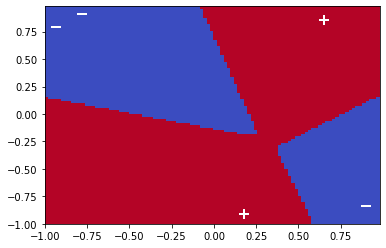

In [386]:
plot_classifier(w_opt_L1, a_opt_L1, x, y)

In [387]:
w_tilde_norms_opt_L1 = calc_w_tilde_norms(w_opt_L1, a_opt_L1)

In [388]:
np.linalg.norm(w_tilde_norms_opt_L1, ord=1)

5.162396293262871

In [389]:
minimal_margin(w_opt_L1, a_opt_L1, x, y)

0.9999994395469926

In [390]:
normalized_margins(w_opt_L1, a_opt_L1, x, y)

array([1.00000056, 1.        , 1.00000052, 1.00000024, 1.00000051])

### Empirical Gradient Flow

In [391]:
def get_s_from_s_val(s_val):
    return [s_val] * m

In [392]:
def train_worker(alpha, s_val, m, d):
    w_0, a_0 = symmetric_init(alpha=alpha, s=get_s_from_s_val(s_val),  m=m, d=d, symmetric=True)
    
    results = {}
    results[s_val] = train(
        w_0=w_0,
        a_0=a_0,
        x=x,
        y=y,
        step_size=1e-6,
        n_epochs=50000000,
        eval_freq=1000)
    
    results[s_val].update({'w_0': w_0, 'a_0': a_0})
    return results

In [393]:
alpha = [100] * m 
s_vals = [0, 0.5, 0.95, -0.5, -0.95, 0.999, -0.999]

In [395]:
pool = mp.Pool(processes=len(s_vals))
pool_output = [pool.apply_async(train_worker, args=(alpha, s_val, m, d)) for s_val in s_vals]
results = {}
[results.update(p_out.get()) for p_out in pool_output]

100%|██████████| 50000000/50000000 [1:06:32<00:00, 12524.22it/s]


[None, None, None, None, None, None, None]

In [404]:
def downsample_results(res_dict, sample_freq=10, start_from=1000, excluded_keys=['w_0', 'a_0']):
    res_dict_downsampled = {}
    for k, v in res_dict.items():
        if not isinstance(v, dict):
            raise NotImplementedError('Expected nested results dict.')
        
        res_dict_downsampled[k] = {}
        for k_v, v_v in v.items():
            if k_v in excluded_keys:
                res_dict_downsampled[k][k_v] = v_v
            else:
                res_dict_downsampled[k][k_v] = v_v[:start_from] + v_v[start_from::sample_freq]
    return res_dict_downsampled

In [405]:
# downsample results
results_GD = downsample_results(results)

In [406]:
np.save(f'../results/GD_{dataset}_alpha_{alpha[0]}_m_{m}.npy',  results_GD) 

In [407]:
# results_GD_restored = np.load('../results/GD_3PTS_alpha_100_m_20_18-12-2020 15-00.npy', allow_pickle=True)
# results_GD = results_GD_restored[()]

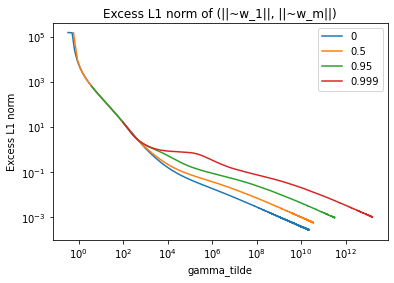

In [408]:
for k, res in results_GD.items():
    if k not in [0, 0.5, 0.95, 0.999]:
        continue
    plot(
        [t for t in res['training_loss']],
        [np.linalg.norm(r, ord=1) - np.linalg.norm(w_tilde_norms_opt_L1, ord=1) for r in res['w_tilde_norms']],
        '')

yscale('log')
xscale('log')
ylabel('Excess L1 norm')
xlabel('gamma_tilde');
title(f'Excess L1 norm of (||~w_1||, ||~w_m||)');
legend([0, 0.5, 0.95, 0.999]);

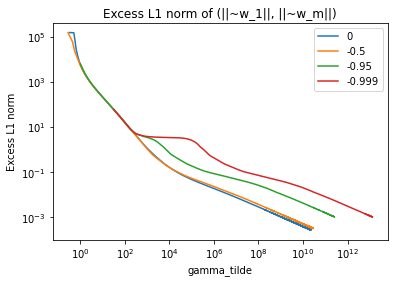

In [409]:
for k, res in results_GD.items():
    if k not in [0, -0.5, -0.95, -0.999]:
        continue
    plot(
        [t for t in res['training_loss']],
        [np.linalg.norm(r, ord=1) - np.linalg.norm(w_tilde_norms_opt_L1, ord=1) for r in res['w_tilde_norms']],
        '')

yscale('log')
xscale('log')
ylabel('Excess L1 norm')
xlabel('gamma_tilde');
title(f'Excess L1 norm of (||~w_1||, ||~w_m||)');
legend([0, -0.5, -0.95, -0.999]);

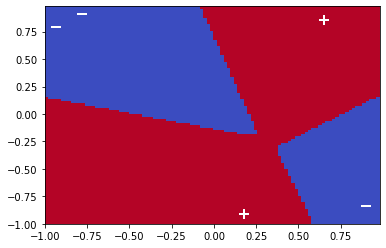

In [411]:
plot_classifier(results_GD[0]['w'][-1], results_GD[0]['a'][-1], x, y)

### S.V stability

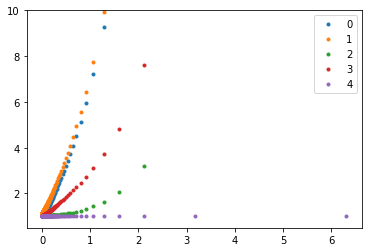

In [415]:
res_GD = results_GD[0]

for idx in range(len(x)):
    plot(
        [2 * alpha[0]/t for t in res['training_loss']],
        [normalized_margins(w, a, x, y)[idx] for t, w, a in zip(res_GD['training_loss'], res_GD['w'], res_GD['a'])],
        '.')
ylim([0.5, 10])
legend(list(range(len(x))))

### Estimate Q Minimization

In [418]:
def run_Q_minimization(alpha, s, w_0, a_0):
    mu_Q = []
    w_array_Q = []
    a_array_Q = []

    for mu_val in tqdm([1e-4, 1e-3, 0.01, 0.1, 0.5, 1, 2, 5, 10, 25, 50, 100, 200, 300, 400, 500, 1000]):
        mu = [mu_val] * m

        NUM_RERIES = 5
        best_Q_val_so_far = np.inf

        for retry in range(NUM_RERIES):
            try:
                w_opt_Q, a_opt_Q = solver(
                    x,
                    y,
                    w_0,
                    a_0,
                    m,
                    d,
                    obj='Q',
                    mu=mu,
                    s=s,
                    x0=np.random.normal(size=(m * (d + 1),)),
                    optim_tol=1e-4
                )

                Q_val = Q_func(w_opt_Q, a_opt_Q, mu, s)
                if (Q_val < best_Q_val_so_far):
                    best_Q_val_so_far = Q_val
                    w_best_Q = w_opt_Q
                    a_best_Q = a_opt_Q

            except Exception as e:
                print(f'Mu = {mu[0]}:: {e}')            

        mu_Q.append(mu_val)
        w_array_Q.append(w_best_Q)
        a_array_Q.append(a_best_Q)
    
    return {
        'mu': mu_Q,
        'w': w_array_Q,
        'a': a_array_Q
    }

In [419]:
def Q_min_worker(alpha, s_val, m, d):
    s = get_s_from_s_val(s_val)
    w_0, a_0 = symmetric_init(alpha=alpha, s=s,  m=m, d=d, symmetric=True)
    
    return {s_val: run_Q_minimization(alpha, s, w_0, a_0)}

In [420]:
pool = mp.Pool(processes=len(s_vals))
pool_output = [pool.apply_async(Q_min_worker, args=(alpha, s_val, m, d)) for s_val in s_vals]
results_Q = {}
[results_Q.update(p_out.get()) for p_out in pool_output]

100%|██████████| 17/17 [04:09<00:00, 14.67s/it]


[None, None, None, None, None, None, None]

In [421]:
np.save(f'../results/Q_dataset_{dataset}_alpha_{alpha[0]}_m_{m}.npy',  results_Q) 

In [422]:
# results_Q_restored = np.load('../results/Q_dataset_3PTS_alpha_100_m_20_18-12-2020 15-15.npy', allow_pickle=True)
# results_Q = results_Q_restored[()]

#### Plot Q - GD match

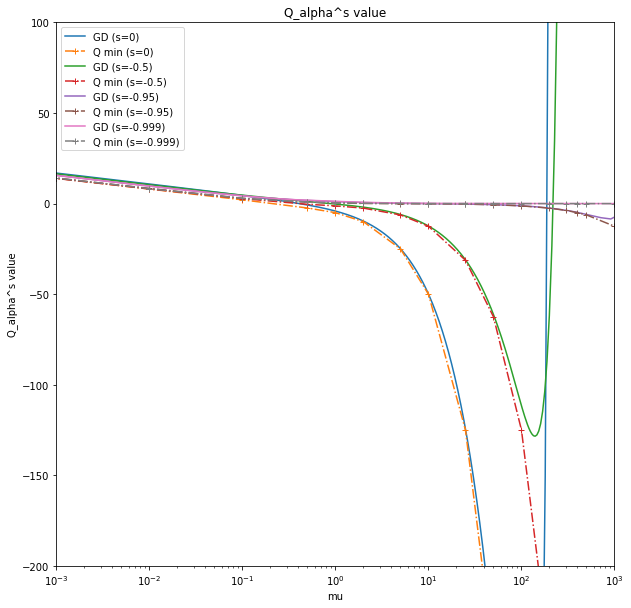

In [465]:
s_vals_to_draw = [0, 0.5, 0.95, 0.999]
legend_ = []

plt.figure(figsize=[10, 10])
for s_val in s_vals_to_draw:
    s = get_s_from_s_val(s_val)
    res_GD = results_GD[s_val]
    res_Q = results_Q[s_val]

    plot(
        [2 * alpha[0]/(1 - s_val**2)/t for t in res_GD['training_loss']],
        [Q_func(w / minimal_margin(w, a, x, y), a.reshape(-1, 1), [2 * alpha[0]/(1 - s_val**2)/t] * m, s)
         for t, w, a in zip(res_GD['training_loss'], res_GD['w'], res_GD['a'])],
        '')

    plot(
        [mu_val for mu_val in res_Q['mu']],
        [Q_func(w, a.reshape(-1, 1), [mu_val] * m, s) 
         for mu_val, w, a in zip(res_Q['mu'], res_Q['w'], res_Q['a'])],
        '-.+')

    legend_.extend([f'GD (s={s_val})', f'Q min (s={s_val})'])
    

ylim([-200, 100])
xlim([1e-3, 1e3])
xscale('log')
ylabel('Q_alpha^s value')
xlabel('mu');
title(f'Q_alpha^s value');
legend(legend_);

##### Plot NTK kerel change over time

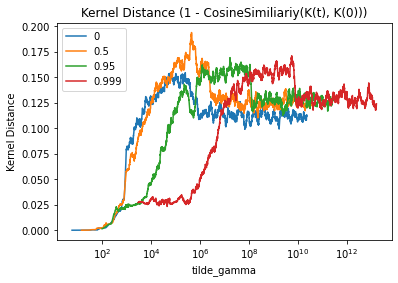

In [464]:
for k, res in results_GD.items():
    if k not in [0, 0.5, 0.95, 0.999]:
        continue

    kernel_distances_smooth = pd.Series(res['kernel_distances']).rolling(50).mean()
    plot([t for t in res['training_loss']], kernel_distances_smooth)

xscale('log')
ylabel('Kernel Distance')
xlabel('tilde_gamma');
title(f'Kernel Distance (1 - CosineSimiliariy(K(t), K(0)))');
legend([0, 0.5, 0.95, 0.999])

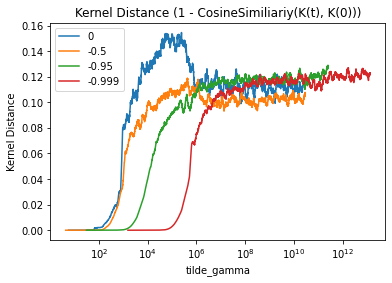

In [463]:
for k, res in results_GD.items():
    if k not in [0, -0.5, -0.95, -0.999]:
        continue

    kernel_distances_smooth = pd.Series(res['kernel_distances']).rolling(50).mean()
    plot([t for t in res['training_loss']], kernel_distances_smooth)

xscale('log')
ylabel('Kernel Distance')
xlabel('tilde_gamma');
title(f'Kernel Distance (1 - CosineSimiliariy(K(t), K(0)))');
legend([0, -0.5, -0.95, -0.999])

##### Plot decision boundary over time

In [453]:
s_val = 0.999
res_GD = results_GD[s_val]

In [454]:
mu_vals = [2 * alpha[0]/(1 - s_val**2)/t for t in res_GD['training_loss']]
print('mu range:' ,max(mu_vals), min(mu_vals))
print('gamma_tilde range:', min(res_GD['training_loss']), max(res_GD['training_loss']))

mu range: 1014.7499560021764 6.264615185406635e-09
gamma_tilde range: 98.59574215373803 15970657742166.389


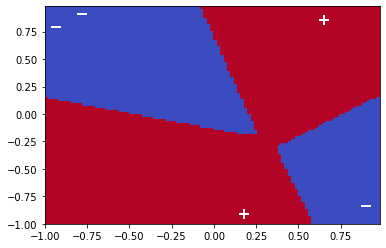

In [455]:
plot_classifier(res_GD['w'][-1], res_GD['a'][-1], x, y)

tilde_gamma=98.59574215373803, mu = 1014.7499560021764, min margin = 97.84911781819048


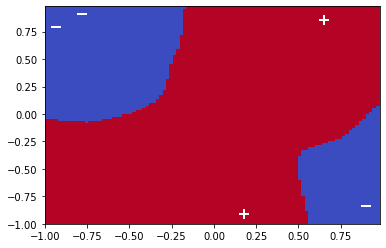

tilde_gamma=13321.159638225468, mu = 7.510609265983949, min margin = 13320.47436207247


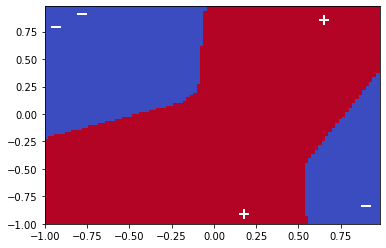

tilde_gamma=26605.42780943798, mu = 3.760511792147013, min margin = 26604.67611018396


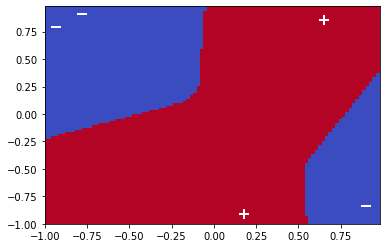

tilde_gamma=40110.20065287651, mu = 2.4943785716348064, min margin = 40109.46296618236


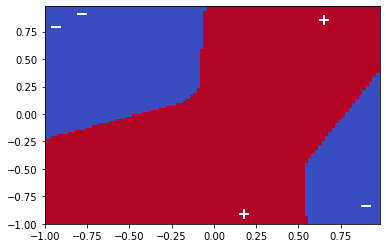

tilde_gamma=53946.87321582624, mu = 1.8546028536674524, min margin = 53946.08117351636


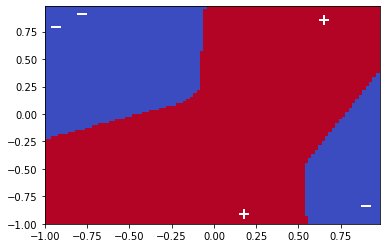

tilde_gamma=188164.4425835619, mu = 0.531715895090415, min margin = 188163.43895595998


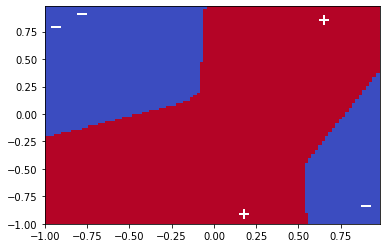

tilde_gamma=513662.121712009, mu = 0.19477789150394445, min margin = 513660.8821617889


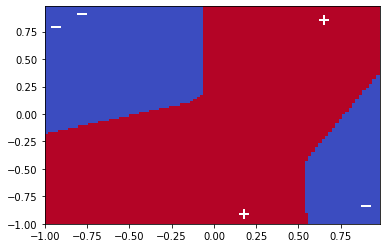

tilde_gamma=1276528.869492048, mu = 0.07837662539690086, min margin = 1276527.2745594785


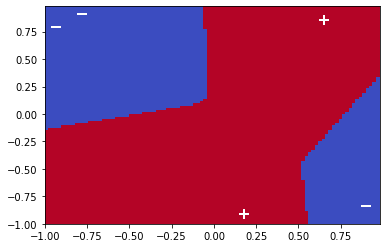

tilde_gamma=3126898.678349341, mu = 0.03199656762313866, min margin = 3126897.8835857958


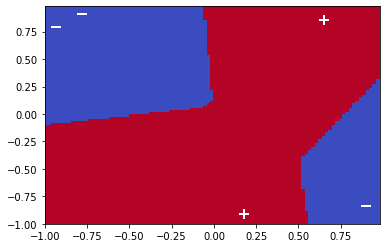

tilde_gamma=7658915.504898599, mu = 0.013063210443895896, min margin = 7658913.89546621


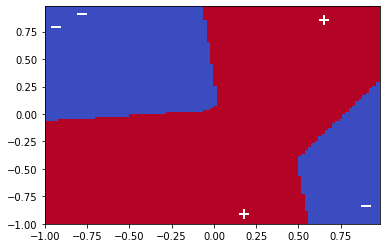

tilde_gamma=18799885.433472376, mu = 0.005321842272207302, min margin = 18799883.824034464


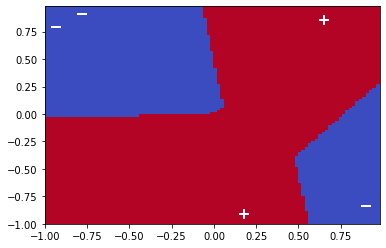

tilde_gamma=46275912.75681703, mu = 0.0021620324495440443, min margin = 46275911.14750214


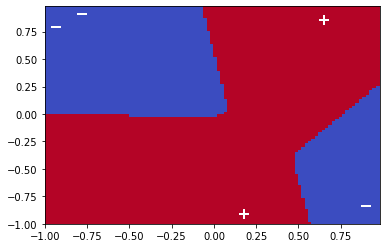

tilde_gamma=114194538.38179632, mu = 0.0008761366912137412, min margin = 114194536.77235872


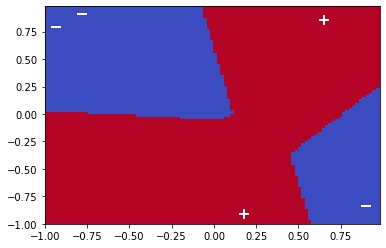

tilde_gamma=282413754.1186508, mu = 0.0003542675367378654, min margin = 282413752.5092129


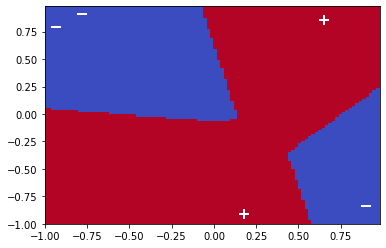

tilde_gamma=699754193.9953605, mu = 0.00014297881437659658, min margin = 699754192.3859226


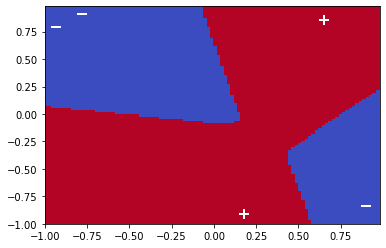

tilde_gamma=1736655989.764904, mu = 5.761073327254159e-05, min margin = 1736655988.155466


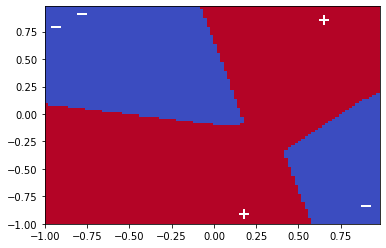

tilde_gamma=4316103039.599394, mu = 2.3180638667466547e-05, min margin = 4316103037.989956


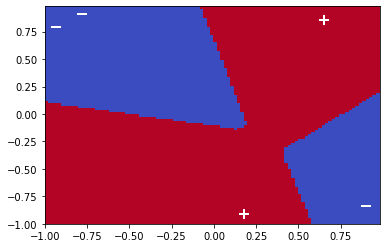

tilde_gamma=10738938810.614187, mu = 9.316565330795984e-06, min margin = 10738938809.00475


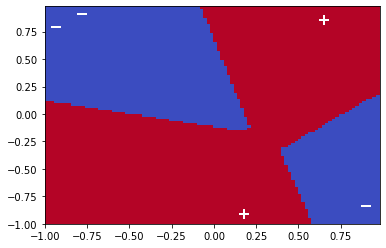

tilde_gamma=26741041693.65158, mu = 3.7414408218906382e-06, min margin = 26741041692.042145


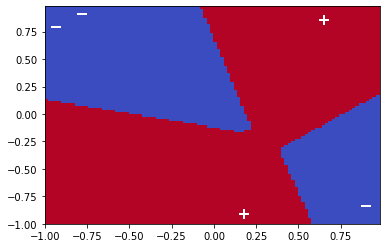

tilde_gamma=66628960527.80882, mu = 1.5015996680715118e-06, min margin = 66628960526.19939


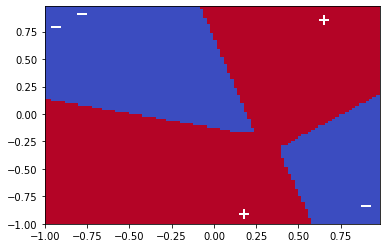

tilde_gamma=166087072447.16626, mu = 6.023950180971152e-07, min margin = 166087072445.55682


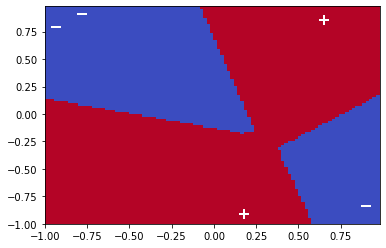

tilde_gamma=414132679040.9933, mu = 2.4158930235641716e-07, min margin = 414132679039.38385


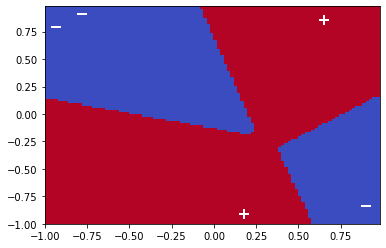

tilde_gamma=1032835490816.7786, mu = 9.686927482845003e-08, min margin = 1032835490815.1691


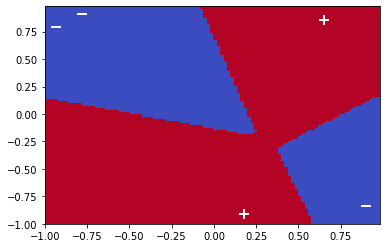

tilde_gamma=2576247104908.172, mu = 3.8835570090266554e-08, min margin = 2576247104906.5625


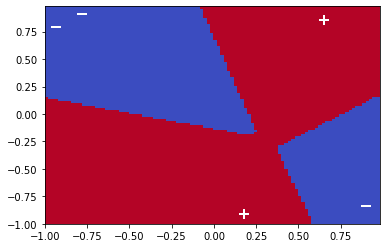

tilde_gamma=6426610138652.537, mu = 1.5568086884679924e-08, min margin = 6426610138650.928


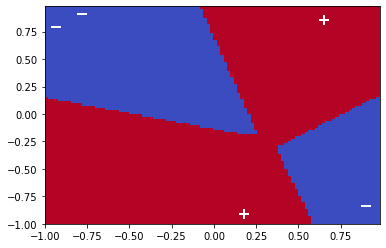

In [445]:
num_plots = 25
idx = 0
for i in range(num_plots):
    print("tilde_gamma={}, mu = {}, min margin = {}".format(
        res_GD['training_loss'][idx],
        2 * alpha[0]/(1 - s_val**2)/res_GD['training_loss'][idx], 
        minimal_margin(res_GD['w'][idx], res_GD['a'][idx], x, y)))
    plot_classifier(res_GD['w'][idx], res_GD['a'][idx], x, y)
    idx += len(res_GD['training_loss']) // num_plots    

##### NTK solution

In [433]:
clf = fit_svm_with_tangent_kernel(res_GD['w_0'], res_GD['a_0'], x, y)

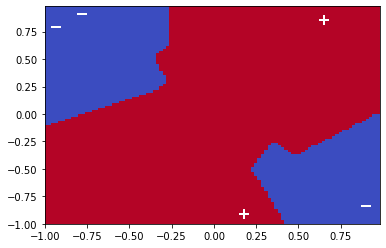

In [434]:
plot_svm_classifier(clf, x, y)

##### Show Q is a good predictor for L1 convergence

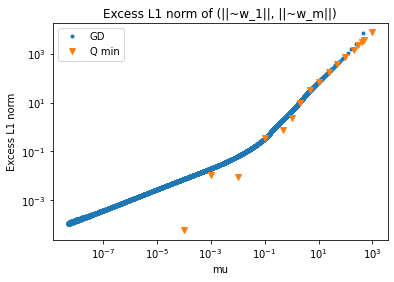

In [251]:
for s_val in [0.5]:
    s = get_s_from_s_val(s_val)
    res_GD = results_GD[s_val]
    res_Q = results_Q[s_val]
    
    plot(
        [2 * alpha[0]/(1 - s_val**2)/t for t in res_GD['training_loss']],
        [np.linalg.norm(r, ord=1) - np.linalg.norm(w_tilde_norms_opt_L1, ord=1) for r in res_GD['w_tilde_norms']],
        '.')
    
    plot(
    [2 * alpha[0]/(1 - s_val**2)/t for t in res_Q['training_loss']],
    [np.linalg.norm(calc_w_tilde_norms(w, a), ord=1) - np.linalg.norm(w_tilde_norms_opt_L1, ord=1) 
     for w, a in zip(res_Q['w'], res_Q['a'])],
    'v')

# plot(
#     [2 * alpha[0]/(1 - s_val**2)/t for t in res_GD['training_loss']],
#     [m * alpha[0]/(1 - s_val**2)/t - np.linalg.norm(w_tilde_norms_opt_L1, ord=1) for t in res_GD['training_loss']])

yscale('log')
xscale('log')
#xlim([1e-4, 1e3])
ylabel('Excess L1 norm')
xlabel('mu');
title(f'Excess L1 norm of (||~w_1||, ||~w_m||)');
legend(['GD', 'Q min', 'linear trend line']);

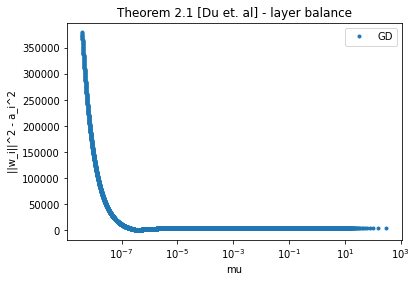

In [252]:
s_val = 0.95
res_GD = results_GD[s_val]
plot(
    [2 * alpha[0]/(1 - s_val**2)/t for t in res_GD['training_loss']],
    [np.abs(np.mean(np.abs(a)**2 - np.linalg.norm(w, ord=2, axis=1)**2)) for w, a in zip(res_GD['w'], res_GD['a'])],
    '.')

xscale('log')
#yscale('log')
ylabel('||w_i||^2 - a_i^2')
xlabel('mu');
title(f'Theorem 2.1 [Du et. al] - layer balance');
legend(['GD']);

### Plot q_s

/Users/shaharazulay/Documents/work/relu-inductive-bias/source/Q_minimization.py:16: RuntimeWarning: divide by zero encountered in log
  return (x * np.log(x + np.sqrt(x**2 + s**2)) - np.sqrt(x**2 + s**2) + np.abs(s)) / 2
/Users/shaharazulay/Documents/work/relu-inductive-bias/source/Q_minimization.py:16: RuntimeWarning: invalid value encountered in double_scalars
  return (x * np.log(x + np.sqrt(x**2 + s**2)) - np.sqrt(x**2 + s**2) + np.abs(s)) / 2


Text(0.5, 1.0, 'q_s')

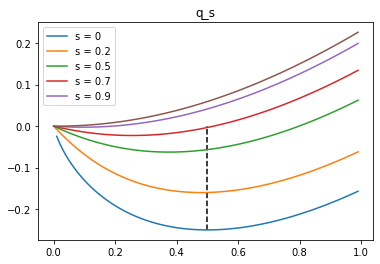

In [366]:
mu = 1
x = list(np.arange(0, mu, 0.01))
for s in [0, 0.2, 0.5, 0.7, 0.9, 0.99]:
    plot(x, list(map(lambda x: q_func(x/mu, s), x)))
    
vlines(0.5, -0.25, 0, linestyles='dashed')
legend([f's = {k}' for k in [0, 0.2, 0.5, 0.7, 0.9]])
title('q_s')